# Price prediction of short-term flat rentals in London

* [Exploratory data analysis](#Exploratory-data-analysis)
* [Interactive plots](#Interactive-plots)
* [Predictive modeling](#Predictive-modeling)
* [Using DBSCAN for cluster similarity search](#Using-DBSCAN-for-cluster-similarity-search)
    * [Fine-tuning silhouette coefficient](#Fine-tuning-silhouette-coefficient)

In [1]:
from pathlib import Path
import itertools
import folium
from folium.plugins import HeatMap
from matplotlib import colormaps
import matplotlib.colors as colors
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.cluster import DBSCAN

In [2]:
pd.options.display.max_rows = None

In [3]:
home_dir = Path.home()
inside_airbnb_data_dir = home_dir / 'Programming/data/inside-airbnb/london'
inside_airbnb_work_dir = home_dir / 'Programming/Python/machine-learning-exercises/short-term-rents-in-london'

In [4]:
inside_airbnb_data_file = inside_airbnb_data_dir / 'selected_short_term_rentals_with_distances.csv'
inside_airbnb_df = pd.read_csv(inside_airbnb_data_file, keep_default_na=False, thousands=',')

In [5]:
inside_airbnb_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1489 entries, 0 to 1488
Data columns (total 13 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   borough              1489 non-null   object 
 1   latitude             1489 non-null   float64
 2   longitude            1489 non-null   float64
 3   property_type        1489 non-null   object 
 4   room_type            1489 non-null   object 
 5   bathrooms            1489 non-null   float64
 6   bedrooms             1489 non-null   float64
 7   price                1489 non-null   float64
 8   minimum_nights       1489 non-null   int64  
 9   crime_rate           1489 non-null   float64
 10  amenities            1489 non-null   object 
 11  nearest_station      1489 non-null   object 
 12  distance_to_station  1489 non-null   float64
dtypes: float64(7), int64(1), object(5)
memory usage: 151.4+ KB


In [6]:
inside_airbnb_df.drop(['room_type', 'nearest_station'], axis=1, inplace=True)

In [7]:
inside_airbnb_df.nunique().sort_values(ascending=False)

distance_to_station    1339
longitude              1332
latitude               1312
price                   331
amenities               233
minimum_nights           66
borough                  33
crime_rate               33
property_type            14
bathrooms                14
bedrooms                 10
dtype: int64

In [8]:
quantiles = np.quantile(inside_airbnb_df.price, [0.0, 0.25, 0.5, 0.75, 1.0])
inside_airbnb_df['price_range'] = pd.cut(inside_airbnb_df.price, bins=quantiles, labels=['low', 'medium', 'high', 'very high'])
inside_airbnb_df['price_range_int'] = inside_airbnb_df['price_range'].cat.rename_categories({'low': 1, 'medium': 2, 'high': 3, 'very high': 4})

In [9]:
inside_airbnb_df.head()

,borough,latitude,longitude,property_type,bathrooms,bedrooms,price,minimum_nights,crime_rate,amenities,distance_to_station,price_range,price_range_int
0,Lambeth,51.491476,-0.111514,Entire rental unit,1.0,1.0,150.0,30,137.98,None,0.520193,medium,2
1,Kensington and Chelsea,51.485660,-0.184150,Entire rental unit,2.0,2.0,195.0,91,118.02,"Nightlife, Restaurant",0.956708,high,3
2,Brent,51.538990,-0.197440,Entire rental unit,1.5,2.0,83.0,30,117.59,Grocery Store,0.481797,low,1
3,Kensington and Chelsea,51.517320,-0.200500,Entire rental unit,1.0,2.0,288.0,91,118.02,Restaurant,0.398479,very high,4
4,Westminster,51.496950,-0.138880,Entire rental unit,3.0,4.0,901.0,186,132.94,"Restaurant, Retail",0.200253,very high,4


In [10]:
inside_airbnb_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1489 entries, 0 to 1488
Data columns (total 13 columns):
 #   Column               Non-Null Count  Dtype   
---  ------               --------------  -----   
 0   borough              1489 non-null   object  
 1   latitude             1489 non-null   float64 
 2   longitude            1489 non-null   float64 
 3   property_type        1489 non-null   object  
 4   bathrooms            1489 non-null   float64 
 5   bedrooms             1489 non-null   float64 
 6   price                1489 non-null   float64 
 7   minimum_nights       1489 non-null   int64   
 8   crime_rate           1489 non-null   float64 
 9   amenities            1489 non-null   object  
 10  distance_to_station  1489 non-null   float64 
 11  price_range          1488 non-null   category
 12  price_range_int      1488 non-null   category
dtypes: category(2), float64(7), int64(1), object(3)
memory usage: 131.4+ KB


## Exploratory data analysis

In [11]:
borough_sr = inside_airbnb_df.borough.value_counts()

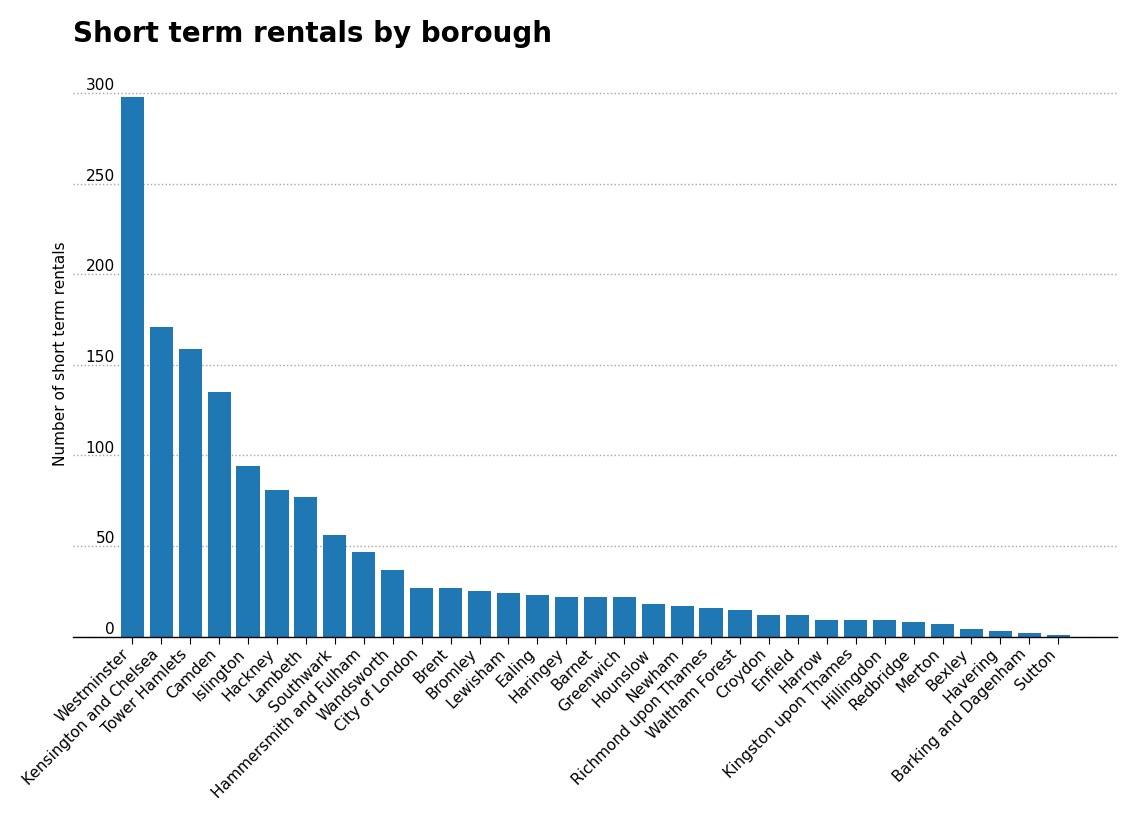

In [12]:
mplstyle_file = inside_airbnb_work_dir / 'barplot-style.mplstyle'
plt.style.use(mplstyle_file)
fig, ax = plt.subplots( nrows=1, ncols=1)
ax.bar(borough_sr.index, borough_sr.values)
ax.set_ylabel('Number of short term rentals')
ax.set_title('Short term rentals by borough')
plt.setp(ax.get_xticklabels(), rotation=45, ha='right')
path_plots = inside_airbnb_work_dir / 'plots'
path_plots.mkdir(exist_ok=True, parents=True)
plot_filename = path_plots / 'short-term-rentals.png'
if not plot_filename.exists():
    plt.savefig(plot_filename, dpi=144, bbox_inches='tight');

In [13]:
prices_data = inside_airbnb_df.price.values
prices_data = prices_data.astype('float')

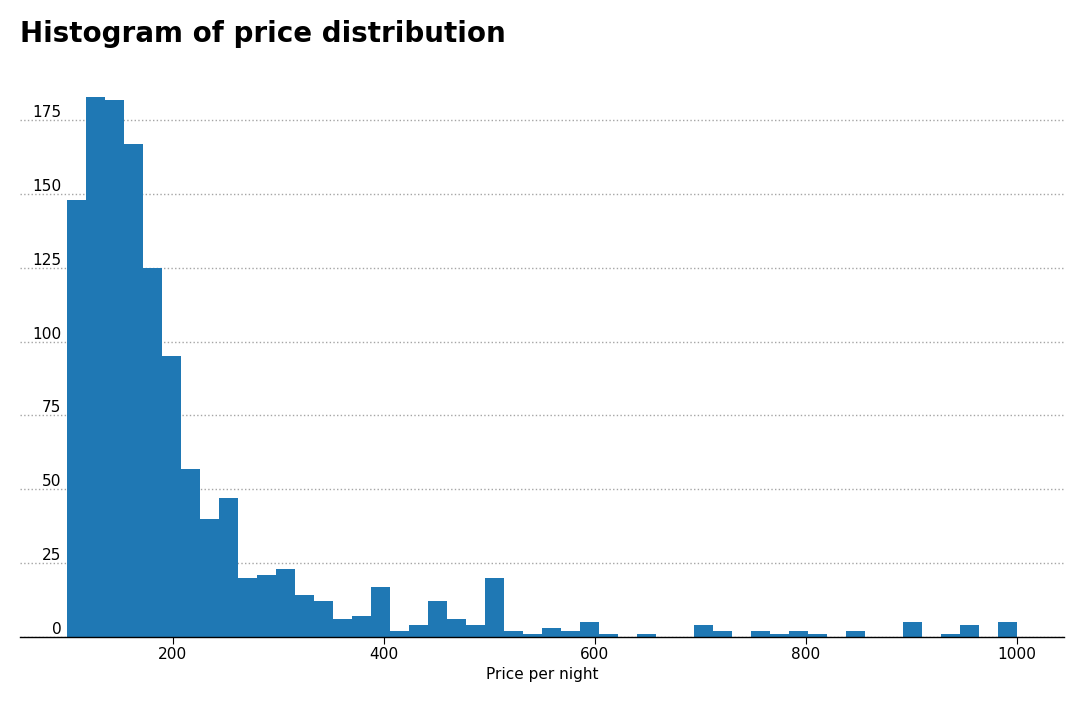

In [14]:
fig, ax = plt.subplots(nrows=1, ncols=1)
ax.hist(prices_data, bins=50, range=[100, 1000])
ax.set_title('Histogram of price distribution')
ax.set_xlabel('Price per night')
plot_filename = path_plots / 'hist_price_distrib.png'
if not plot_filename.exists():
    plt.savefig(plot_filename, dpi=144, bbox_inches='tight');

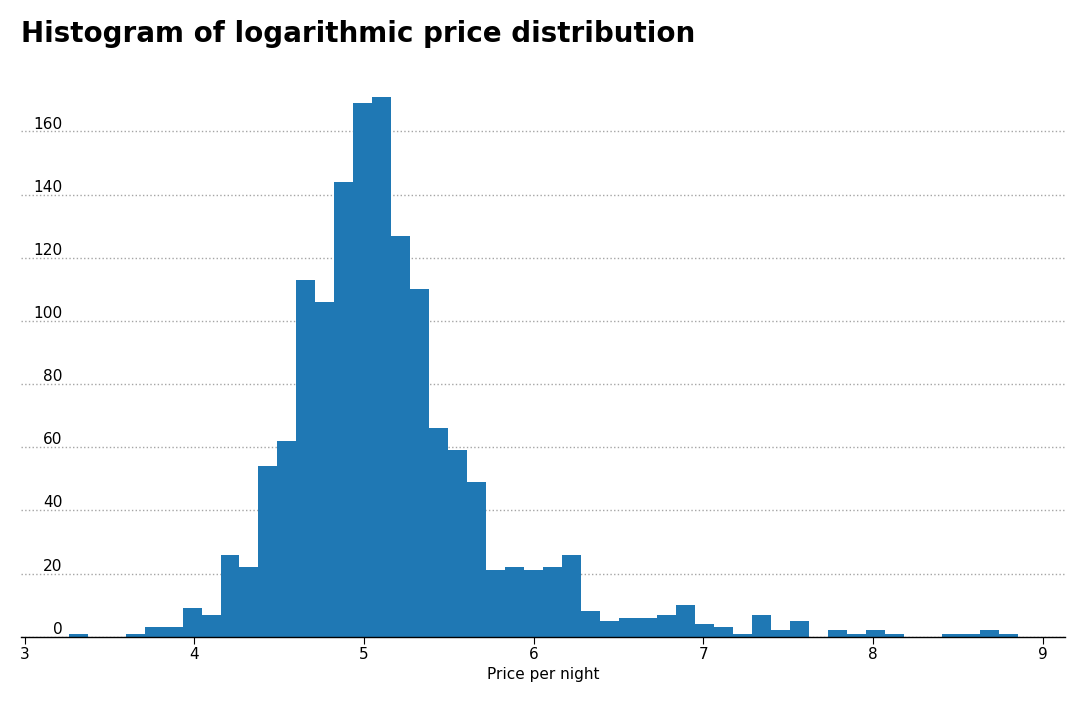

In [15]:
fig, ax = plt.subplots(nrows=1, ncols=1)
ax.hist(np.log1p(prices_data), bins=50)
ax.set_title('Histogram of logarithmic price distribution')
ax.set_xlabel('Price per night')
plot_filename = path_plots / 'hist_log_price_distrib.png'
if not plot_filename.exists():
    plt.savefig(plot_filename, dpi=144, bbox_inches='tight');

In [16]:
min_nights_data = inside_airbnb_df.minimum_nights.values
min_nights_data = min_nights_data.astype('int')

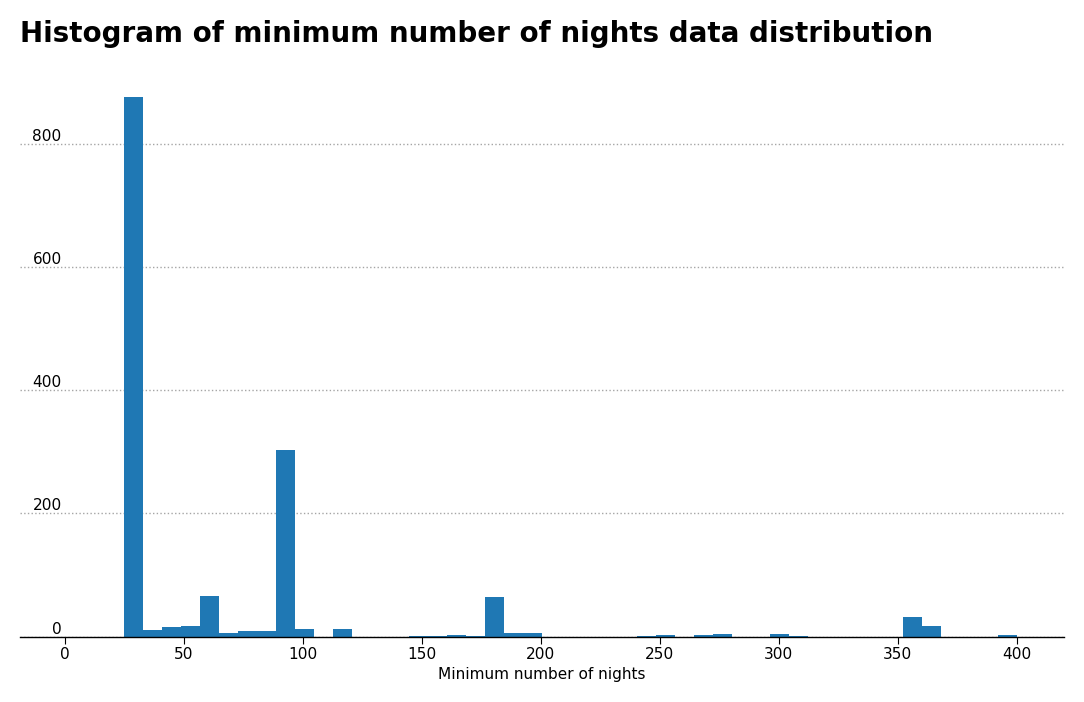

In [17]:
fig, ax = plt.subplots(nrows=1, ncols=1)
ax.hist(min_nights_data, bins=50, range=[1, 400])
ax.set_title('Histogram of minimum number of nights data distribution')
ax.set_xlabel('Minimum number of nights')
plot_filename = path_plots / 'min_nights_data_distrib.png'
if not plot_filename.exists():
    plt.savefig(plot_filename, dpi=144, bbox_inches='tight');

In [18]:
property_type_sr = inside_airbnb_df.property_type.value_counts()

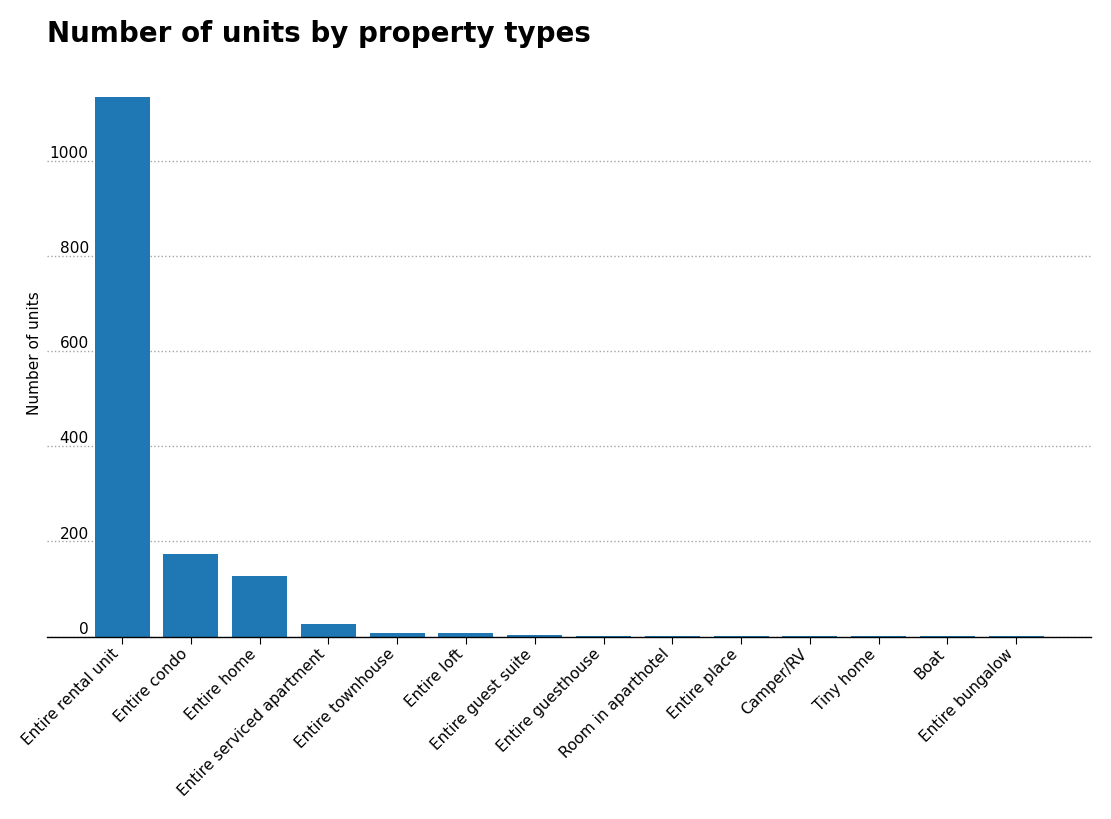

In [19]:
fig, ax = plt.subplots( nrows=1, ncols=1)
ax.bar(x=property_type_sr.index, height=property_type_sr.values)
ax.set_ylabel('Number of units')
ax.set_title('Number of units by property types')
plt.setp(ax.get_xticklabels(), rotation=45, ha='right')
plot_filename = path_plots / 'num_units_property.png'
if not plot_filename.exists():
    plt.savefig(plot_filename, dpi=144, bbox_inches='tight');

In [20]:
average_price_per_borough_sr = inside_airbnb_df.price.groupby(inside_airbnb_df.borough).mean()
average_price_per_borough_sr.sort_values(ascending=False, inplace=True)

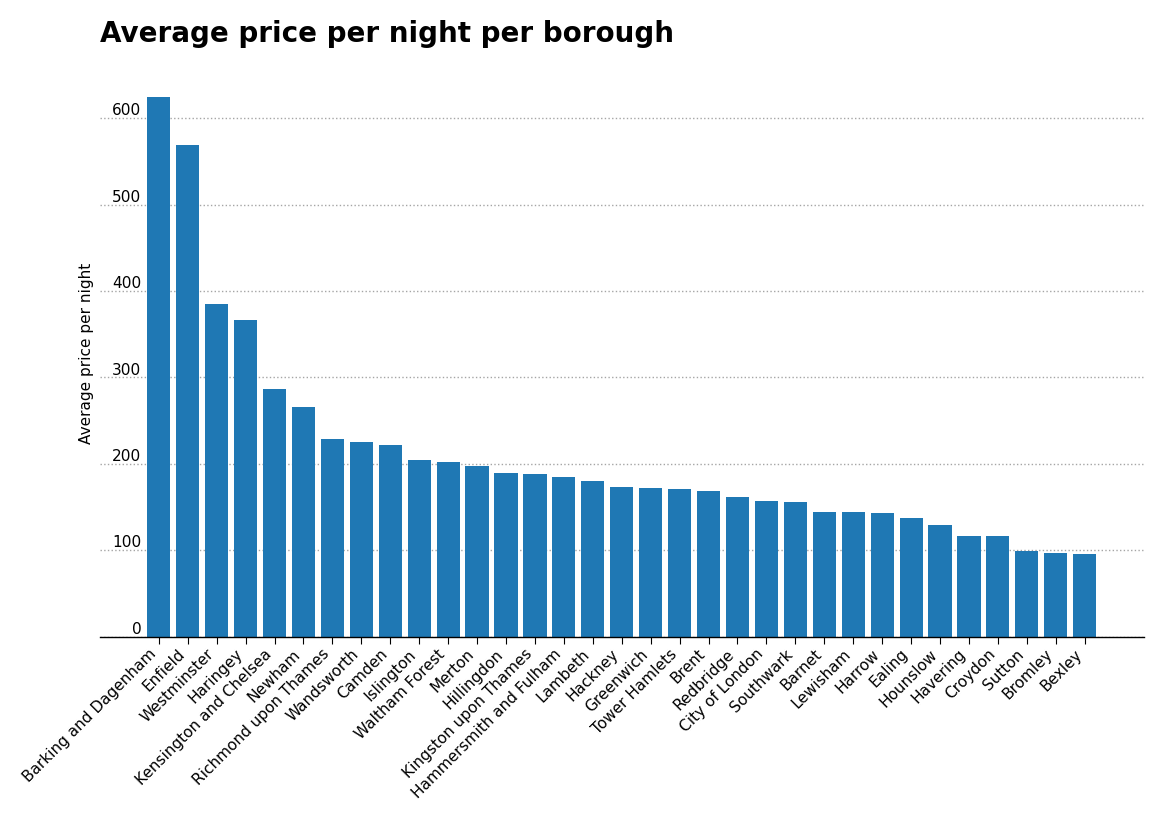

In [21]:
fig, ax = plt.subplots(nrows=1, ncols=1)
ax.bar(average_price_per_borough_sr.index, average_price_per_borough_sr.values)
plt.setp(ax.get_xticklabels(), rotation=45, ha='right')
ax.set_ylabel('Average price per night')
ax.set_title('Average price per night per borough')
plot_filename = path_plots / 'average_price_borough.png'
if not plot_filename.exists():
    plt.savefig(plot_filename, dpi=144, bbox_inches='tight');

## Interactive plots

In [22]:
london_map_1 = folium.Map(location=[51.5074, -0.1278], zoom_start=12, tiles='CartoDB Voyager')

In [23]:
borough_names = inside_airbnb_df['borough'].unique()
num_locations = len(borough_names)
colormap = list(itertools.chain(
    colormaps['tab20b'].colors,
    colormaps['tab20c'].colors
))
location_colors = {loc: colors.rgb2hex(colormap[i]) for i, loc in enumerate(borough_names)}

In [24]:
for _, row in inside_airbnb_df.iterrows():
    folium.CircleMarker(
        location=[row['latitude'], row['longitude']],
        radius=row['price']/100,
        color=location_colors[row['borough']],
        fill=True,
        fill_color=location_colors[row['borough']],
        fill_opacity=0.6,
        weight=0,
    ).add_to(london_map_1)

In [25]:
path_plots = inside_airbnb_work_dir / 'html'
path_plots.mkdir(exist_ok=True, parents=True)
density_map_file = inside_airbnb_work_dir / 'html/density_map.html'
if not density_map_file.exists():
    london_map_1.save(density_map_file)
london_map_1

In [26]:
london_map_2 = folium.Map(location=[51.5074, -0.1278], zoom_start=12, tiles='CartoDB Voyager')

In [27]:
_ = HeatMap(
        inside_airbnb_df[['latitude', 'longitude']].values,
        radius=20,
        blur=10,
        min_opacity=0.2,
        max_opacity=0.8,
).add_to(london_map_2)

In [28]:
heat_map_file = inside_airbnb_data_dir / 'html/heat_map.html'
if not heat_map_file.exists():
    london_map_2.save(inside_airbnb_work_dir / 'html/heat_map.html')
london_map_2

In [29]:
london_map_3 = folium.Map(location=[51.5074, -0.1278], zoom_start=12, tiles='CartoDB Voyager')

In [30]:
for _, row in inside_airbnb_df.iterrows():
    folium.CircleMarker(
        location=[row['latitude'], row['longitude']],
        radius=row['price_range_int']*4,
        color=location_colors[row['borough']],
        fill=True,
        fill_color=location_colors[row['borough']],
        fill_opacity=0.6,
        weight=0,
    ).add_to(london_map_3)

In [31]:
path_plots = inside_airbnb_work_dir / 'html'
path_plots.mkdir(exist_ok=True, parents=True)
density_map_file = inside_airbnb_work_dir / 'html/_price_range.html'
if not density_map_file.exists():
    london_map_3.save(density_map_file)
london_map_3

## Predictive modeling

In [32]:
df_full_train, df_test = train_test_split(inside_airbnb_df, test_size=0.2, random_state=33)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=33)

In [33]:
df_train.shape, df_val.shape, df_test.shape

((893, 13), (298, 13), (298, 13))

In [34]:
df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

In [35]:
y_train = df_train.price.values
y_val = df_val.price.values
y_test = df_test.price.values

In [36]:
X_train = df_train.drop('price', axis=1)
X_val = df_val.drop('price', axis=1)
X_test = df_test.drop('price', axis=1)

In [37]:
X_train.head()

,borough,latitude,longitude,property_type,bathrooms,bedrooms,minimum_nights,crime_rate,amenities,distance_to_station,price_range,price_range_int
0,Haringey,51.589000,-0.098600,Entire rental unit,1.0,2.0,90,133.11,"Home Improvement, Organization",0.298332,very high,4
1,Tower Hamlets,51.501474,-0.019168,Entire rental unit,1.0,1.0,30,98.60,Restaurant,0.221129,medium,2
2,Kensington and Chelsea,51.493210,-0.179090,Entire condo,2.0,2.0,31,118.02,"Education, Restaurant",0.272535,very high,4
3,Kensington and Chelsea,51.495486,-0.185166,Entire rental unit,1.0,1.0,91,118.02,"Healthcare, Organization, Transport",0.187728,low,1
4,City of London,51.510113,-0.084078,Entire rental unit,1.0,1.0,30,28.93,Restaurant,0.137911,medium,2


In [38]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 893 entries, 0 to 892
Data columns (total 12 columns):
 #   Column               Non-Null Count  Dtype   
---  ------               --------------  -----   
 0   borough              893 non-null    object  
 1   latitude             893 non-null    float64 
 2   longitude            893 non-null    float64 
 3   property_type        893 non-null    object  
 4   bathrooms            893 non-null    float64 
 5   bedrooms             893 non-null    float64 
 6   minimum_nights       893 non-null    int64   
 7   crime_rate           893 non-null    float64 
 8   amenities            893 non-null    object  
 9   distance_to_station  893 non-null    float64 
 10  price_range          892 non-null    category
 11  price_range_int      892 non-null    category
dtypes: category(2), float64(6), int64(1), object(3)
memory usage: 72.0+ KB


### Using DBSCAN for cluster similarity search

In [39]:
X_geo = inside_airbnb_df[['latitude', 'longitude']]
db = DBSCAN(eps=0.03, min_samples=10, algorithm='auto').fit(X_geo)
labels = db.labels_

In [40]:
# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

In [41]:
print("Estimated number of clusters: {:d}".format(n_clusters_))
print("Estimated number of noise points: {:d}".format(n_noise_))

Estimated number of clusters: 3
Estimated number of noise points: 71


In [42]:
print(f"Silhouette Coefficient: {metrics.silhouette_score(X_geo, labels):.3f}")

Silhouette Coefficient: 0.463


#### Fine-tuning silhouette coefficient

In [43]:
sil_score_list = []
sil_score_range = np.linspace(0.01, 0.1, 10)
for eps_param in sil_score_range:
    db = DBSCAN(eps=eps_param, min_samples=10, algorithm='auto').fit(X_geo)
    labels = db.labels_
    sil_score = metrics.silhouette_score(X_geo, labels)
    sil_score_list.append(sil_score)

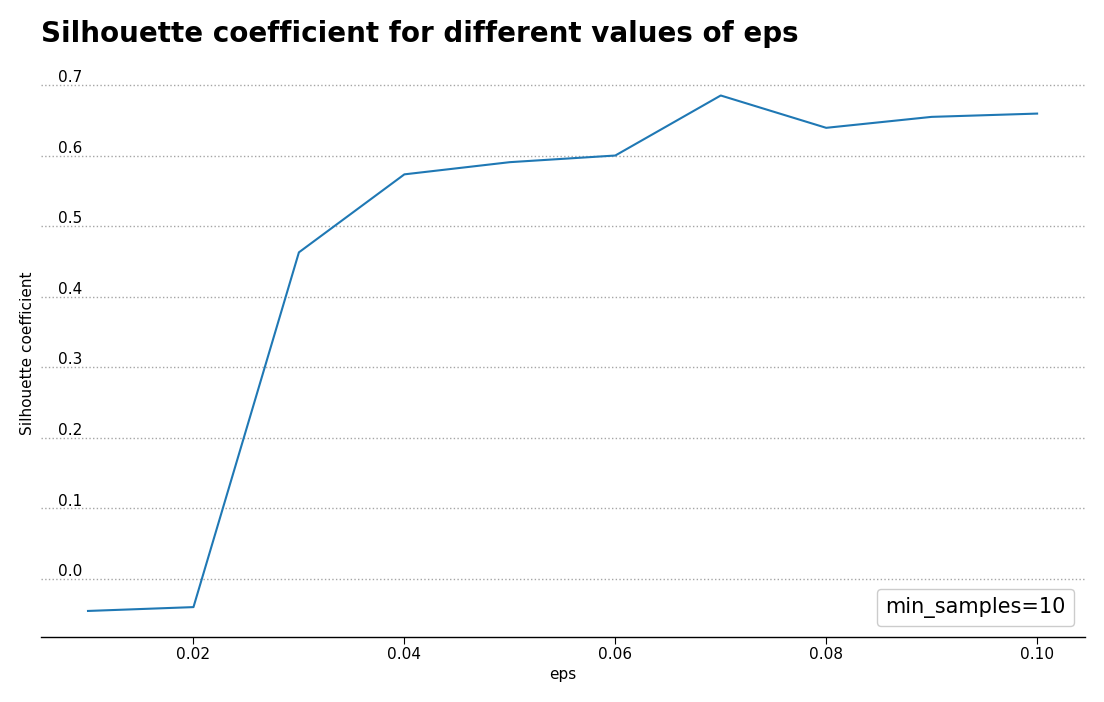

In [44]:
fig, ax = plt.subplots()
ax.plot(sil_score_range, sil_score_list, label='min_samples=10')
ax.legend(loc=4, handlelength=0, handletextpad=0, prop={'size': 15})
ax.set_xlabel("eps")
ax.set_ylabel("Silhouette coefficient")
ax.set_title("Silhouette coefficient for different values of eps");

In [45]:
sil_score_list = []
min_sample_range = np.linspace(2, 30, 29)
for min_sample in min_sample_range:
    db = DBSCAN(eps=0.07, min_samples=int(min_sample), algorithm='auto').fit(X_geo)
    labels = db.labels_
    sil_score = metrics.silhouette_score(X_geo, labels)
    sil_score_list.append(sil_score)

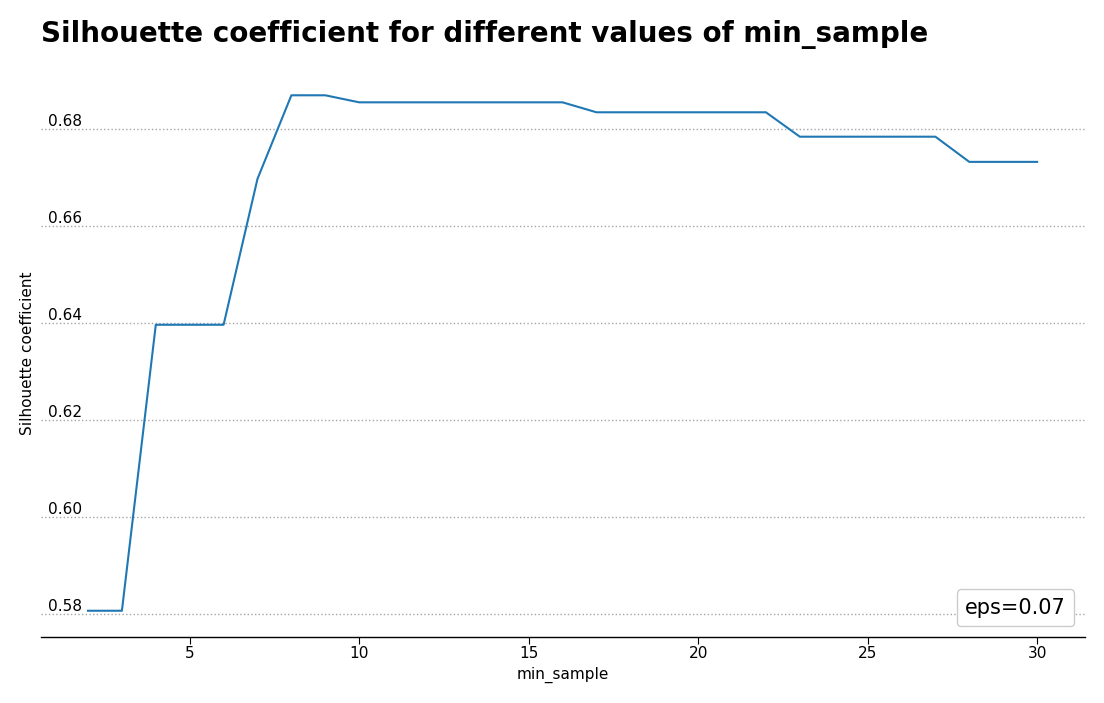

In [46]:
fig, ax = plt.subplots()
ax.plot(min_sample_range, sil_score_list, label='eps=0.07')
ax.legend(loc=4, handlelength=0, handletextpad=0, prop={'size': 15})
ax.set_xlabel("min_sample")
ax.set_ylabel("Silhouette coefficient")
ax.set_title("Silhouette coefficient for different values of min_sample");